# Leak Tests

In [1]:
import numpy as np
import torch
import pickle
from tqdm import tqdm
from joblib import Parallel, delayed
from pyro.distributions.empirical import Empirical


# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# sbi
import sbibm
from sbibm.metrics import c2st
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils
from sbi import analysis
from sbibm.metrics import c2st
from sbi.utils import (
    batched_mixture_mv,
    batched_mixture_vmv,
    check_dist_class,
    clamp_and_warn,
    del_entries,
    repeat_rows,
)


# distances
from scipy.spatial.distance import directed_hausdorff

In [2]:
slcp = sbibm.get_task("slcp")  # See sbibm.get_available_tasks() for all tasks
slcp_simulator = slcp.get_simulator()
slcp_prior = slcp.get_prior_dist()

## Test simulate_for_sbi

In [3]:
num_rounds = 2
posteriors = []
simulator, prior = prepare_for_sbi(slcp_simulator, slcp_prior)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    if i==0:
        theta, x= simulate_for_sbi(simulator, proposal, num_simulations=1000, num_workers=7)
    else:
        theta, x, leaky_theta, x_nan= simulate_for_sbi(simulator, proposal, num_simulations=1000, num_workers=7, rejection=False)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train(loss_function='default')
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(slcp.get_observation(1))


/home/tt21642/PycharmProjects/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2985.)
  m = torch.stack(


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

exception calling callback for <Future at 0x7f99715d1160 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/home/tt21642/anaconda3/envs/sbi-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 407, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/home/tt21642/anaconda3/envs/sbi-env/lib/python3.9/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
  File "/home/tt21642/PycharmProjects/sbibm/sbibm/__init__.py", line 2, in <module>
    from sbibm.tasks import get_available_tasks, get_task, get_task_name_display
  File "/home/tt21642/PycharmProjects/sbibm/sbibm/tasks/__init__.py", line 4, in <module>
    from sbibm.tasks.task import Task
  File "/home/tt21642/PycharmProjects/sbibm/sbibm/tasks/task.py", line 6, in <module>
    import pandas as pd
  File "/home/tt21642/anaconda3/envs/sbi-env/lib/pytho

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [ ]:
inference.append_leaky_samples(leaky_theta,x_nan, proposal=proposal)

In [ ]:
inference._theta_roundwise

In [ ]:
test = torch.tensor([[0,1],[2,3],[torch.nan, torch.nan]])

In [15]:
nan_mask = test.isnan()

In [27]:
batch_size = 10
test_theta = theta[:batch_size]
num_atoms = 3
probs = torch.ones(batch_size, batch_size) * (1 - torch.eye(batch_size)) / (batch_size - 1)
choices = torch.multinomial(probs, num_samples=num_atoms - 1, replacement=False)
contrasting_theta = test_theta[choices]


In [28]:
atomic_theta = torch.cat((test_theta[:, None, :], contrasting_theta), dim=1).reshape(
    batch_size * num_atoms, -1
)


In [29]:
test_theta

tensor([[ 1.6812e+00,  8.6569e-01,  2.3035e+00, -5.7123e-01,  5.6345e-01],
        [ 4.5840e-01, -5.4698e-01,  5.6648e-01, -1.3421e+00, -1.0161e+00],
        [-4.8817e-01, -6.5886e-01, -1.9798e+00, -1.9148e+00,  1.6915e+00],
        [ 1.1513e+00,  2.1175e+00, -1.7016e-01, -1.8569e+00,  1.8345e+00],
        [ 1.1219e+00,  3.2805e-04,  2.8523e-01,  6.3366e-01,  8.6140e-01],
        [ 1.8383e+00, -1.2195e-01,  2.2543e+00,  1.1066e+00,  9.5699e-01],
        [-1.3299e+00, -6.0148e-01, -1.8700e+00,  1.0877e+00,  2.8440e-01],
        [ 2.4770e-01,  5.0910e-01, -2.7664e+00,  2.0451e+00, -9.0699e-01],
        [-1.2532e-01,  5.8887e-01, -2.9514e+00, -8.0513e-01,  2.2574e+00],
        [ 5.7841e-01,  4.9260e-02,  2.2284e+00,  7.5367e-02,  1.0505e-01]])

In [30]:
atomic_theta # Note, 0, 3, 6, 9... elements are original, i.e, source of x.

tensor([[ 1.6812e+00,  8.6569e-01,  2.3035e+00, -5.7123e-01,  5.6345e-01],
        [ 1.1513e+00,  2.1175e+00, -1.7016e-01, -1.8569e+00,  1.8345e+00],
        [ 1.1219e+00,  3.2805e-04,  2.8523e-01,  6.3366e-01,  8.6140e-01],
        [ 4.5840e-01, -5.4698e-01,  5.6648e-01, -1.3421e+00, -1.0161e+00],
        [-1.3299e+00, -6.0148e-01, -1.8700e+00,  1.0877e+00,  2.8440e-01],
        [ 1.6812e+00,  8.6569e-01,  2.3035e+00, -5.7123e-01,  5.6345e-01],
        [-4.8817e-01, -6.5886e-01, -1.9798e+00, -1.9148e+00,  1.6915e+00],
        [ 1.8383e+00, -1.2195e-01,  2.2543e+00,  1.1066e+00,  9.5699e-01],
        [ 2.4770e-01,  5.0910e-01, -2.7664e+00,  2.0451e+00, -9.0699e-01],
        [ 1.1513e+00,  2.1175e+00, -1.7016e-01, -1.8569e+00,  1.8345e+00],
        [ 1.6812e+00,  8.6569e-01,  2.3035e+00, -5.7123e-01,  5.6345e-01],
        [ 2.4770e-01,  5.0910e-01, -2.7664e+00,  2.0451e+00, -9.0699e-01],
        [ 1.1219e+00,  3.2805e-04,  2.8523e-01,  6.3366e-01,  8.6140e-01],
        [ 1.1513e+00,  2.

In [34]:
repeated_x = repeat_rows(x[:10], num_atoms)
log_prob_posterior = inference._neural_net.log_prob(atomic_theta, repeated_x)

In [39]:
log_prob_posterior.reshape(batch_size,num_atoms)

tensor([[-10.3785, -16.4281, -19.5338],
        [ -6.7118, -12.5611, -25.8564],
        [ -9.3215, -10.4840, -19.1019],
        [ -8.3395, -50.4817, -19.2718],
        [ -3.1659,  -9.5910, -28.8611],
        [ -8.1000, -16.6577, -13.9505],
        [ -7.7228, -19.7075, -73.3489],
        [-12.7285, -17.2606, -14.8602],
        [-10.8737, -13.2673, -12.7130],
        [ -7.8814, -20.0283,  -8.7663]], grad_fn=<ReshapeAliasBackward0>)

## Design loss function for leaky Theta

In [71]:
batch_size = 20
test_theta = torch.cat([theta[:15], leaky_theta[:5]])
test_x = torch.cat([x[:15],x_nan[:5]])
nan_mask = test_x.isnan()
theta_valid = test_theta[~nan_mask.any(dim=1)]
theta_valid_dim = theta_valid.size(0)
num_atoms = 3
probs = torch.ones(batch_size, batch_size) * (1 - torch.eye(batch_size)) / (batch_size - 1)
probs = probs[~nan_mask.any(dim=1)]
choices = torch.multinomial(probs, num_samples=num_atoms - 1, replacement=False)
contrasting_theta = test_theta[choices]
atomic_theta = torch.cat((theta_valid[:, None, :], contrasting_theta), dim=1).reshape(
    theta_valid_dim * num_atoms, -1
)


In [82]:
repeated_x = repeat_rows(test_x[~nan_mask.any(dim=1)], num_atoms)
log_prob_posterior = inference._neural_net.log_prob(atomic_theta, repeated_x).reshape(theta_valid_dim,num_atoms)

In [83]:
log_prob_prior = slcp_prior.log_prob(atomic_theta).reshape(theta_valid_dim, num_atoms)
log_prob_prior

tensor([[-8.9588, -8.9588, -8.9588],
        [-8.9588, -8.9588,    -inf],
        [-8.9588, -8.9588, -8.9588],
        [-8.9588, -8.9588,    -inf],
        [-8.9588,    -inf, -8.9588],
        [-8.9588, -8.9588, -8.9588],
        [-8.9588, -8.9588, -8.9588],
        [-8.9588, -8.9588, -8.9588],
        [-8.9588,    -inf, -8.9588],
        [-8.9588,    -inf, -8.9588],
        [-8.9588, -8.9588, -8.9588],
        [-8.9588, -8.9588, -8.9588],
        [-8.9588, -8.9588, -8.9588],
        [-8.9588, -8.9588, -8.9588],
        [-8.9588, -8.9588,    -inf]])

In [87]:
log_prob_prior[log_prob_prior==-torch.inf]=0

In [88]:
log_prob_prior

tensor([[-8.9588, -8.9588, -8.9588],
        [-8.9588, -8.9588,  0.0000],
        [-8.9588, -8.9588, -8.9588],
        [-8.9588, -8.9588,  0.0000],
        [-8.9588,  0.0000, -8.9588],
        [-8.9588, -8.9588, -8.9588],
        [-8.9588, -8.9588, -8.9588],
        [-8.9588, -8.9588, -8.9588],
        [-8.9588,  0.0000, -8.9588],
        [-8.9588,  0.0000, -8.9588],
        [-8.9588, -8.9588, -8.9588],
        [-8.9588, -8.9588, -8.9588],
        [-8.9588, -8.9588, -8.9588],
        [-8.9588, -8.9588, -8.9588],
        [-8.9588, -8.9588,  0.0000]])

In [90]:
unnormalised_log_prob = log_prob_posterior-log_prob_prior

In [92]:
unnormalised_log_prob[:,0]- torch.logsumexp(unnormalised_log_prob, dim=-1)

tensor([-2.8824e-02, -4.7183e-03, -2.7210e-01,  0.0000e+00, -3.9873e-03,
        -6.5816e-02, -4.2861e-02, -5.0344e-02, -1.4749e-01, -8.6546e-05,
        -3.8388e-01, -3.2427e-03, -1.0562e-04, -5.9605e-07, -9.9659e-04],
       grad_fn=<SubBackward0>)

## All together

/home/tt21642/PycharmProjects/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2985.)
  m = torch.stack(


Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 140 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

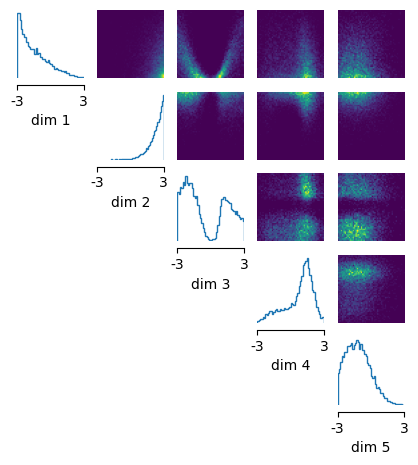

tensor(0.1227)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 63 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

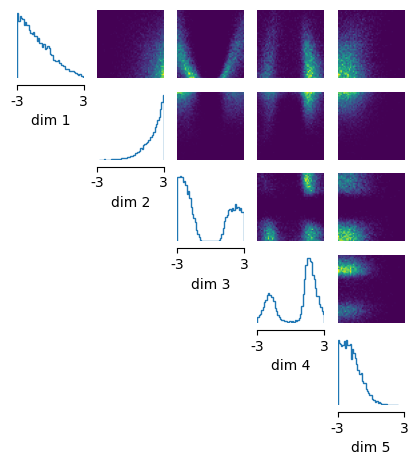

tensor(0.0153)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 41

KeyboardInterrupt: 

In [3]:
# num_rounds = 10
# posteriors = []
# simulator, prior = prepare_for_sbi(slcp_simulator, slcp_prior)
# proposal = prior
# inference = SNPE(prior=prior)
# for i in range(num_rounds):
#     theta, x= simulate_for_sbi(simulator, proposal, num_simulations=1000)
#     density_estimator = inference.append_simulations(theta, x, proposal=proposal).train(loss_function='default', num_norm_samples=1)
#     if i>0:
#         density_estimator = inference.train(loss_function='correction', num_norm_samples=5)
#     posterior = inference.build_posterior(density_estimator)
#     posteriors.append(posterior)
#     proposal = posterior.set_default_x(slcp.get_observation(1))
#     samples, acceptance_rate = posterior.sample((10000,), return_acceptance_rate=True)
#     analysis.pairplot(samples,
#                         limits=[[-3,3], [-3,3],[-3,3],[-3,3],[-3,3]],
#                         ticks=[[-3,3],[-3,3],[-3,3],[-3,3],[-3,3]],
#                         figsize=(5,5),
#                         points_offdiag={'markersize': 6},
#                         points_colors='r');
#     plt.show()
#     print(acceptance_rate)

num_rounds = 10
posteriors = []
simulator, prior = prepare_for_sbi(slcp_simulator, slcp_prior)
proposal = prior
inference = SNPE(prior=prior)
acceptance_rate = 1
for i in range(num_rounds):
    theta, x= simulate_for_sbi(simulator, proposal, num_simulations=1000)
    correction_frequency= 0.1
    num_norm_samples = 5
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train(loss_function='weighted', num_norm_samples=num_norm_samples, stop_after_epochs=30,leak_correction_frequency=correction_frequency)
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(slcp.get_observation(5))
    samples, acceptance_rate = posterior.sample((10000,), return_acceptance_rate=True)
    analysis.pairplot(samples,
                        limits=[[-3,3], [-3,3],[-3,3],[-3,3],[-3,3]],
                        ticks=[[-3,3],[-3,3],[-3,3],[-3,3],[-3,3]],
                        figsize=(5,5),
                        points_offdiag={'markersize': 6},
                        points_colors='r');
    plt.show()
    print(acceptance_rate)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

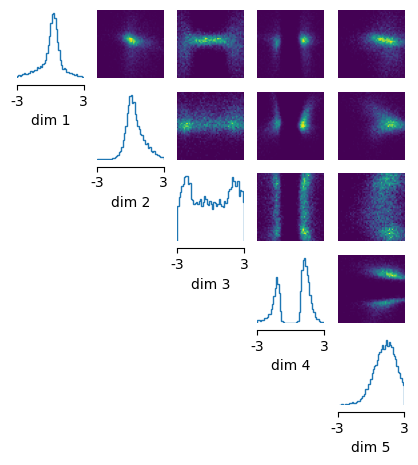

tensor(0.3926)


In [4]:
# samples, acceptance_rate = posterior.sample((10000,), return_acceptance_rate=True)
# analysis.pairplot(samples,
#                     limits=[[-3,3], [-3,3],[-3,3],[-3,3],[-3,3]],
#                     ticks=[[-3,3],[-3,3],[-3,3],[-3,3],[-3,3]],
#                     figsize=(5,5),
#                     points_offdiag={'markersize': 6},
#                     points_colors='r');
# plt.show()
# print(acceptance_rate)

In [5]:
reference_samples = slcp.get_reference_posterior_samples(5)
c2st(samples, reference_samples)

tensor([0.8324])

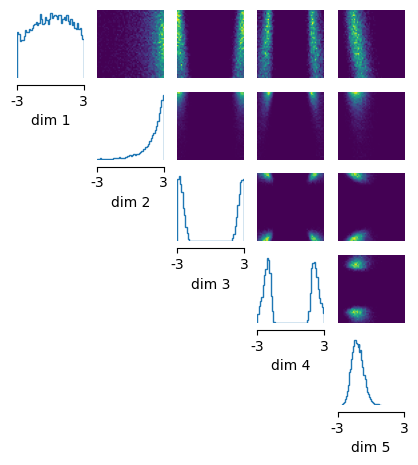

In [6]:
analysis.pairplot(reference_samples,
                    limits=[[-3,3], [-3,3],[-3,3],[-3,3],[-3,3]],
                    ticks=[[-3,3],[-3,3],[-3,3],[-3,3],[-3,3]],
                    figsize=(5,5),
                    points_offdiag={'markersize': 6},
                    points_colors='r'); 
plt.show()

In [5]:
len(inference.get_simulations(exclude_invalid_x=False)[0])

15466

In [8]:
samples, leaks, acceptance = posterior.sample((1000,), rejection=False, return_acceptance_rate=True)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 995 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


In [11]:
len(leaks)

6614

In [8]:
extra_samples = inference._neural_net.sample(10, context=x[0:2])

In [14]:
extra_samples.reshape(2*10,-1)

tensor([[ -3.8239,   0.6484,   1.8189,  -0.4169,  -1.5097],
        [ -4.6454,   3.2345,  -1.0907,   1.9739,   0.8292],
        [ -3.3864,   0.7330,   2.1929,  -0.1790,  -2.6217],
        [ -9.5526,   0.1232,  -3.1131,  -1.6988,  -1.0345],
        [ -4.8447,   1.2915,  -1.2771,   0.8051,  -0.4730],
        [ -4.1587,   1.6025,  -1.6476,   0.9495,  -2.4154],
        [ -5.9614,   1.2320,  -2.5156,   1.4072,   0.6889],
        [ -5.3651,   0.7246,  -1.1828,  -1.6275,  -1.4217],
        [ -5.8692,   6.2943,   2.5182,   3.5939,   0.2332],
        [ -5.0623,   0.9830,   1.8244,  -0.2996,  -2.1008],
        [ -1.5363,  11.7380,  -0.3329,  -4.2730,  -1.1979],
        [ -2.2087,   5.0236,  -0.8996,   0.9932,   2.5550],
        [ -2.0389,   4.5350,   0.1984,   0.8344,   2.4286],
        [ 12.5259,   3.9275,   6.2504,  -0.5663,   1.3883],
        [ -1.7860,   0.7577,  -0.1649,  -3.1220,  -0.2410],
        [ -1.5068,   1.3682,   2.5269,  -4.1124,  -0.0588],
        [ -4.7801,   4.4452,   2.9740,  

In [13]:
t1=torch.tensor([[1,2],[3,-torch.inf]])
t2=torch.tensor([[5,6],[7,8]])
torch.logsumexp(torch.cat([t1,t2],dim=1),dim=1)

tensor([6.3314, 8.3182])

In [16]:
torch.logsumexp(torch.tensor([3,7,8]), dim=-1)

tensor(8.3182)

In [60]:
samples = inference._neural_net.sample(10, context=x[0:2]).reshape(2 * 10, -1).detach()
inference._prior.log_prob(samples)

tensor([-8.9588, -8.9588, -8.9588, -8.9588, -8.9588, -8.9588, -8.9588, -8.9588,
        -8.9588,    -inf, -8.9588, -8.9588, -8.9588, -8.9588, -8.9588, -8.9588,
        -8.9588, -8.9588,    -inf, -8.9588])

In [61]:
discard_mask = (inference._prior.log_prob(samples) == -torch.inf)

In [62]:
repeated_x = repeat_rows(x[0:2], 10)
log_posteriors = inference._neural_net.log_prob(samples, repeated_x)

In [63]:
numerator = log_posteriors
numerator[discard_mask] = -torch.inf

In [66]:
numerator.reshape(2,10).logsumexp(dim=-1)

tensor([-0.5727, -0.6687], grad_fn=<LogsumexpBackward0>)

In [68]:
denominator = log_posteriors


In [6]:
torch.logsumexp(torch.tensor([-torch.inf, -torch.inf, -torch.inf]), dim=-1)

tensor(-inf)

In [4]:
extra_samples = inference._neural_net.sample(10, context=x[0:2])

In [5]:
keep_mask = ~(inference._prior.log_prob(extra_samples) == -torch.inf)

In [24]:
keep_mask.reshape(2,10)

tensor([[ True,  True,  True,  True,  True,  True, False,  True, False,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True, False, False]])

In [25]:
keep_mask[0,0]=False

In [26]:
keep_mask[1,0:2]=False

In [27]:
keep_mask

tensor([[False,  True,  True,  True,  True,  True, False,  True, False,  True],
        [False, False,  True,  True,  True,  True,  True,  True, False, False]])

In [28]:
descending_indices = torch.arange(keep_mask.shape[1],0,-1)

In [32]:
torch.argmax(descending_indices * keep_mask, 1, keepdim=True)

tensor([[1],
        [2]])

In [33]:
descending_indices * keep_mask

tensor([[0, 9, 8, 7, 6, 5, 0, 3, 0, 1],
        [0, 0, 8, 7, 6, 5, 4, 3, 0, 0]])